In [211]:
import os
import time
import re
import math
import numpy as np
import pdfplumber
from decimal import Decimal
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pwd

/Users/zhoubin/Desktop/tpl_ALFramework/pdf_convert/catalogue_extract


# 1. 用pdfplumber解析目录

In [3]:
# 识别流程一 detect_catalog_pagination
import re
def detect_catalog_pagination(pdf):
        catalog_type = 'clean'
        # 定位一、二
        for i, page in enumerate(pdf.pages):
                if [i for i in page.extract_text().split('\n') if i.strip().replace(' ', '') in ('目录', '条款目录')]:
                    return i, catalog_type
                if [i for i in page.extract_text().split('\n') if ''.join(re.findall(u"([\u4e00-\u9fa5])",i)) in ('目录', '条款目录')]:
                    catalog_type = 'impurity'
                    return i, catalog_type
        # 定位三
        for i, page in enumerate(pdf.pages):
            if '条款目录' in page.extract_text().strip().replace(' ',''):
                catalog_type = 'impurity'
                return i, catalog_type
        return -1, catalog_type

## 1.1 form_1 目录比较清晰，按顺序下来，没有左右的情况）（左右情况见富德人寿） clean的情况

In [4]:
feePDF = 'data/1-太平荣耀钻账户终身寿险（万能型）条款.pdf'
pdf = pdfplumber.open(feePDF)
catalog_idx, catalog_type = detect_catalog_pagination(pdf)
catalog_idx, catalog_type

(1, 'clean')

In [5]:
a1 = pdf.pages[1].extract_text()
a2 = pdf.pages[2].extract_text()

In [9]:
def check(lst_1, lst_2):
    return (lst_1[-1]+1 == lst_2[0]) or (lst_1[-1]+1 ==lst_2[-1]) or (lst_1[0]+1 == lst_2[0])
def catalog_ext_form1(page_text, next_page_text):
    flag = False
    next_page_flag = False
    next_res = []
    chn_eng_digittran = Chn_Eng_digitTran()
    page_text_clean = [i.strip() for i in page_text.split('\n') if i.strip() and not re.findall(r'[\u4e00-\u9fa5]+\d+[\u4e00-\u9fa5]*', i) and \
     (i.strip().replace(' ', '') != '条款目录' and i.strip().replace(' ', '') != '目录')]
    curt_res = [re.sub(r'\.\.+', '', i).split() for i in page_text_clean]
    curt_last_two = [chn_eng_digittran.trans(re.sub(r'第|条|部分','', i[0])) for i in curt_res[-2:]]
    # check next page if has catalog
    next_page_0 = [[re.sub(r'\.\.+', '', j) for j in i.split() if j] for i in next_page_text.split('\n')]
    next_page_1 = [i[0] for i in next_page_0 if i and re.findall(r'(?:第[一二三四五六七八九十零]+部分)|(?:第[一二三四五六七八九十零]+条)', i[0])]
    if len(next_page_1) >= 2:
        next_last_two = [chn_eng_digittran.trans(re.sub(r'第|条|部分','', i)) for i in next_page_1]
        next_page_flag = not next_page_flag if check(curt_last_two, next_last_two) else next_page_flag
    if len(next_page_1) == 1:
        next_page_flag = not next_page_flag if (curt_last_two[-1]+1==chn_eng_digittran.trans(re.sub(r'第|条|部分','', next_page_1[0]))) else next_page_flag 
    if next_page_flag:
        next_page_text_clean = [i for i in next_page_text.split('\n') if re.findall(r'(?:第[一二三四五六七八九十零]+部分)|(?:第[一二三四五六七八九十零]+条)',i)]
        next_res = [re.sub(r'\.\.+', '', i).split() for i in next_page_text_clean]
    
    return curt_res + next_res

In [14]:
b = catalog_ext_form1(a1, a2)

In [8]:
# small_tools 将汉字数字转成阿拉伯数字
class Chn_Eng_digitTran:
    '''init'''
    def __init__(self):
        self.digit = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9}

    def _trans(self, s):
        num = 0
        if s:
            idx_q, idx_b, idx_s = s.find('千'), s.find('百'), s.find('十')
            if idx_q != -1:
                num += self.digit[s[idx_q - 1:idx_q]] * 1000
            if idx_b != -1:
                num += self.digit[s[idx_b - 1:idx_b]] * 100
            if idx_s != -1:
                # 十前忽略一的处理
                num += self.digit.get(s[idx_s - 1:idx_s], 1) * 10
            if s[-1] in self.digit:
                num += self.digit[s[-1]]
        return num

    def trans(self, chn):
        chn = chn.replace('零', '')
        idx_y, idx_w = chn.rfind('亿'), chn.rfind('万')
        if idx_w < idx_y:
            idx_w = -1
        num_y, num_w = 100000000, 10000
        if idx_y != -1 and idx_w != -1:
            return self.trans(chn[:idx_y]) * num_y + self._trans(chn[idx_y + 1:idx_w]) * num_w + self._trans(chn[idx_w + 1:])
        elif idx_y != -1:
            return self.trans(chn[:idx_y]) * num_y + self._trans(chn[idx_y + 1:])
        elif idx_w != -1:
            return self._trans(chn[:idx_w]) * num_w + self._trans(chn[idx_w + 1:])
        return self._trans(chn)


## 1.2 form_2 目录竖的下来，可能有两三列（比如天安人寿）
### 考虑clean和impurity两种情况

In [728]:
# feePDF = 'data/华康C款团体重大疾病保险条款.pdf'
feePDF = 'data/1-太平荣耀钻账户终身寿险（万能型）条款.pdf'
feePDF = 'data/天安人寿爱守护（至尊保）终身重大疾病保险条款.pdf'
pdf = pdfplumber.open(feePDF)
catalog_idx, catalog_type = detect_catalog_pagination(pdf)
catalog_idx, catalog_type

(0, 'clean')

In [729]:
for i, page in enumerate(pdf.pages):
    a = page.extract_text()
    if i == 0:
        break

In [292]:
'''
从条款目录开始
过滤掉目录到最后杂质
'''

'\n从条款目录开始\n过滤掉目录到最后杂质\n'

In [478]:
# 版本一
def catalog_ext_form2(page_text):
    flag = False
    res = []
    for s in page_text.split('\n'):
        if s.strip().replace(' ', '') in ('目录', '条款目录'):
            flag = True
            continue
        if flag:
            lst = re.findall(r'(?:\d\.\d*[\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', s.strip().replace('．', '.').replace(' ', ''))
            if not lst:
                continue
            lst = [re.findall(r'(\d\.\d*)([\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', i)[0] for i in lst]
            res += lst
    return sorted(res, key=lambda x : (float(x[0].split('.')[0]), len(x[0]), float(x[0])))

In [245]:
# 版本二
def catalog_ext_form2(page_text):
    flag = False
    res = []
    _d = dict()
    _d_i = 97
    for s in page_text.split('\n'):
        if s.strip().replace(' ', '') in ('目录', '条款目录'):
            flag = True
            continue
        if flag:
            l1 = re.findall(r'\d+种', s)
            if l1:
                s = s.replace(l1[0], '龘龘'+chr(_d_i))
                _d.setdefault('龘龘'+chr(_d_i), l1[0])
                _d_i += 1
            lst = re.findall(r'(?:\d+\.\d*[\u4e00-\u9fa5]+[a-z]*\d*[\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', s.strip().replace('．', '.').replace(' ', ''))
            if not lst:
                continue
            lst = [re.findall(r'(\d+\.\d*)([\u4e00-\u9fa5]+[a-z]*\d*[\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', i)[0] for i in lst]
            for k, v in lst:
                l2 = re.findall(r'龘龘[a-z]+', v)
                if l2:
                    v = v.replace(l2[0], _d[l2[0]])
                res.append((k, v))
    return sorted(res, key=lambda x : (float(x[0].split('.')[0]), len(x[0]), float(x[0])))

In [236]:
# 版本三
def catalog_ext_form2(page_text):
    flag = False
    res = []
    _d = dict()
    _d_i = 97
    for s in page_text.split('\n'):
        if s.strip().replace(' ', '') in ('目录', '条款目录'):
            flag = True
            continue
        if flag:
            # 85种xxx的情况
            l1 = re.findall(r'\d+种', s)
            if l1:
                s = s.replace(l1[0], '龘龘'+chr(_d_i))
                _d.setdefault('龘龘'+chr(_d_i), l1[0])
                _d_i += 1

            # 目录数标没有点的情况，比如 【5 保险费的交纳  10其他需要关注的事项】
            l3 = re.findall(r'(?:^\d+(?!\.)\s+)|(?:\s+\d+(?!\d+)(?!\.))(?!种)', s)
            if l3:
                for i in l3:
                    s = s.replace(i, ' '+i.strip()+'. ')
            #
            lst = re.findall(r'(?:\d+\.\d*[\u4e00-\u9fa5]+[a-z]*\d*[\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', s.strip().replace('．', '.').replace(' ', ''))
            if not lst:
                continue
            lst = [re.findall(r'(\d+\.\d*)([\u4e00-\u9fa5]+[a-z]*\d*[\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', i)[0] for i in lst]
            for k, v in lst:
                l2 = re.findall(r'龘龘[a-z]+', v)
                if l2:
                    v = v.replace(l2[0], _d[l2[0]])
                res.append((k, v))
    return sorted(res, key=lambda x : (float(x[0].split('.')[0]), len(x[0]), float(x[0])))

In [730]:
# small tools
def xmerge(a, b):
    alen, blen = len(a), len(b)
    mlen = min(alen, blen)
    for i in range(mlen):
        yield a[i]
        yield b[i]

    if alen > blen:
        for i in range(mlen, alen):
            yield a[i]
    else:
        for i in range(mlen, blen):
            yield b[i]

In [731]:
# 版本四
def catalog_ext_form2(page_text, mode):
    flag = False
    res = []
    _d = dict()
    _d_i = 97
    for s in page_text.split('\n'):
        if not flag:
            if mode == 'clean' and s.strip().replace(' ', '') in ('目录', '条款目录'):
                flag = True
                continue
            if mode == 'impurity' and ('条款目录' in s.strip().replace(' ', '') or '目录' in s.strip().replace(' ', '')):
                flag = True
                continue
        if flag:
            # 85种xxx的情况
            l1 = re.findall(r'\d+种', s)
            if l1:
                s = s.replace(l1[0], '龘龘'+chr(_d_i))
                _d.setdefault('龘龘'+chr(_d_i), l1[0])
                _d_i += 1
            # 先把字符串合并，即strip然后去掉所有空格
            s = s.strip().replace('．', '.').replace(' ', '')
            # 目录数标没有点的情况，比如 【5保险费的交纳10其他需要关注的事项】
            l3 = re.findall(r'\d+\.*\d*', s)
            if l3:
                l3_1 = re.split(r'\d+\.*\d*', s)
                l3 = [i+'.' if '.' not in i else i for i in l3]
                s = ''.join([i for i in xmerge(l3_1, l3)])
            #
            lst = re.findall(r'(?:\d+\.\d*[\u4e00-\u9fa5]+[a-z]*\d*[\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', s)
            if not lst:
                continue
            lst = [re.findall(r'(\d+\.\d*)([\u4e00-\u9fa5]+[a-z]*\d*[\u4e00-\u9fa5]+[、，!！&%@#$]*[\u4e00-\u9fa5]*)', i)[0] for i in lst]
            for k, v in lst:
                l2 = re.findall(r'龘龘[a-z]+', v)
                if l2:
                    v = v.replace(l2[0], _d[l2[0]])
                res.append((k, v))
    return sorted(res, key=lambda x : (float(x[0].split('.')[0]), len(x[0]), float(x[0])))

In [15]:
# mode = 'impurity'
mode = 'clean'
catalog_ext_form2(a, mode)

# 2. 用pdfplumber解析文本

In [107]:
feePDF = 'data/1-太平附加共享荣耀多次给付重大疾病保险条款.pdf'
pdf = pdfplumber.open(feePDF)

In [108]:
a = pdf.pages[2]

In [194]:
a.extract_words()

[{'bottom': Decimal('99.272'),
  'text': '第一部分',
  'top': Decimal('87.272'),
  'x0': Decimal('121.460'),
  'x1': Decimal('169.676')},
 {'bottom': Decimal('99.272'),
  'text': '您（投保人）与我们（太平人寿保险有限公司）的合同',
  'top': Decimal('87.272'),
  'x0': Decimal('192.410'),
  'x1': Decimal('481.546')},
 {'bottom': Decimal('129.909'),
  'text': '第一条',
  'top': Decimal('119.349'),
  'x0': Decimal('53.880'),
  'x1': Decimal('85.560')},
 {'bottom': Decimal('129.909'),
  'text': '保险合同的构成',
  'top': Decimal('119.349'),
  'x0': Decimal('96.504'),
  'x1': Decimal('170.424')},
 {'bottom': Decimal('145.509'),
  'text': '本附加合同依您的申请，可附加于我们提供的主合同之上，经我们审核同意，并在保险单或批注中列明',
  'top': Decimal('134.949'),
  'x0': Decimal('74.904'),
  'x1': Decimal('549.205')},
 {'bottom': Decimal('161.109'),
  'text': '后生效。',
  'top': Decimal('150.549'),
  'x0': Decimal('53.880'),
  'x1': Decimal('96.004')},
 {'bottom': Decimal('176.709'),
  'text': '主合同的条款中与本附加合同相关的部分均为本附加合同的构成部分，如果主合同与本附加合同的条款',
  'top': Decimal('166.149'),
  'x0': Dec

In [261]:
def get_horizontal_parts_for_one_page(page):
    np_lst = np.zeros(round(page.bbox[3]))
    np_lst_len = len(np_lst)
    words_lst = page.extract_words()
    for words in words_lst:
        idx_set = set(list(range(round(words['top']), round(words['bottom']))))
        np_lst += [1 * (float(words['x1'])-float(words['x0'])) if i in idx_set else 0 for i in range(np_lst_len)]
    s_encode = ''.join(map(lambda x: str(math.ceil(x))[0], np_lst))
    res = list(re.finditer(r'0{10,}', s_encode))
    
    # plot
    sns.plt.plot(np_lst)
    for i in res:
        sns.plt.plot(list(i.span()),[0,0], 'r')  
    
    return res

[<_sre.SRE_Match object; span=(0, 87), match='0000000000000000000000000000000000000000000000000>,
 <_sre.SRE_Match object; span=(99, 119), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(192, 213), match='000000000000000000000'>,
 <_sre.SRE_Match object; span=(240, 260), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(302, 322), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(348, 368), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(380, 400), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(442, 463), match='000000000000000000000'>,
 <_sre.SRE_Match object; span=(505, 525), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(583, 626), match='0000000000000000000000000000000000000000000'>,
 <_sre.SRE_Match object; span=(774, 808), match='0000000000000000000000000000000000'>]

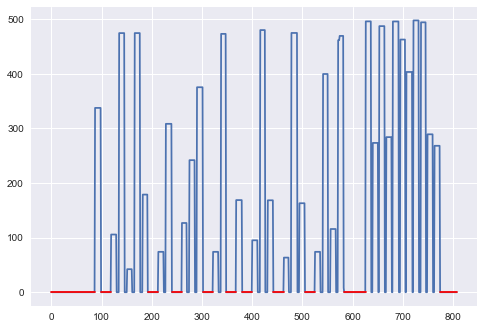

In [263]:
c = get_horizontal_parts_for_one_page(a)
c

In [217]:
s = ''.join(map(lambda x: str(math.ceil(x))[0], np_lst))
s

'0000000000000000000000000000000000000000000000000000000000000000000000000000000000000003333333333330000000000000000000011111111111000004444444444400000444444444400000444444444440000011111111110000000000000000000007777777777700003333333333330000000000000000000011111111110000022222222222000033333333333300000000000000000000777777777770000044444444440000000000000000000011111111111100000000000000000000999999999990000044444444440000011111111111000000000000000000000666666666600000444444444444000011111111111000000000000000000007777777777700000444444444400000111111111110000444444444448000000000000000000000000000000000000000000044444444444000222222222220044444444444000222222222220044444444444400044444444440044444444444400444444444440000444444444400022222222222000222222222220000000000000000000000000000000000'

In [237]:
list(re.finditer(r'0{10,}', s))

[<_sre.SRE_Match object; span=(0, 87), match='0000000000000000000000000000000000000000000000000>,
 <_sre.SRE_Match object; span=(99, 119), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(192, 213), match='000000000000000000000'>,
 <_sre.SRE_Match object; span=(240, 260), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(302, 322), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(348, 368), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(380, 400), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(442, 463), match='000000000000000000000'>,
 <_sre.SRE_Match object; span=(505, 525), match='00000000000000000000'>,
 <_sre.SRE_Match object; span=(583, 626), match='0000000000000000000000000000000000000000000'>,
 <_sre.SRE_Match object; span=(774, 808), match='0000000000000000000000000000000000'>]

In [245]:
a.crop((Decimal('0'), Decimal('626'), Decimal('595.320'), Decimal('774'))).extract_text()

'1周岁：指按照居民身份证、军官证、警官证、士兵证等有效身份证件中记载的出生日期计算的年龄，自出生\n之日起为零周岁，每经过一年增加一岁，不足一年的不计。 \n2保单年度：从保险合同生效日或年生效对应日零时起至下一年度保险合同生效对应日零时止为一个保单年\n度。如果当月无对应的同一日，则以该月最后一日为对应日。 \n3保险费约定支付日：指在本附加合同交费期限内，保险单或批注上列明的合同生效日在每月、每季、每半年\n或每年（根据交费方式确定）的对应日。如果当月无对应的同一日，则以该月最后一日作为对应日。 \n4意外伤害事故：指外来的、突发的、非本意的、非疾病的使身体受到伤害的客观事件。 \n5医院：国务院卫生行政部门医院等级分类中的二级或二级以上的医院，但不包括主要为门诊、康复、护理、\n疗养、戒酒、戒毒或相类似的医疗机构。同时该医院必须具有符合有关医院管理规定设置标准的医疗设备，\n并且提供24小时有合格医师及护士驻院的医疗和护理等服务。 \n太平附加共享荣耀多次给付重大疾病保险，第3页，共20页 '

In [69]:
# a.crop((Decimal('0'), Decimal('524.830'), Decimal('524.830'), Decimal('540.430'))).to_image()

# 3. 用lxml解析html文本

In [34]:
import lxml
from lxml import etree

# 4. 前两种方法结合